In [ ]:
import torch
import torch.nn as nn
import numpy as np
import wandb
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [ ]:
def load_file(file_path, train_size = 0.65, valid_size = 0.15):
    df = pd.read_csv(file_path)
    temps = df['T (degC)'].astype('float32').values
    data_len = len(temps)

    train = temps[:int(data_len*train_size)]
    valid = temps[int(data_len*train_size):int(data_len*(train_size + valid_size))]
    test = temps[int(data_len*(train_size + valid_size)): ]

    return train, valid, test

In [ ]:
def get_loaders(train, valid, test, samples_distance, batch_size = 256):

    def prepare_samples(X):
      data_len = len(X)
      data = []
      target = []
      start = 0
      while data_len - start >= 37:
          data.append(X [start: start + 30])
          target.append(X[start + 30: start + 37])
          start += samples_distance

      data = torch.tensor(data, dtype=torch.float32).unsqueeze(-1)
      target = torch.tensor(target, dtype=torch.float32)

      return data, target

    X_train, y_train = prepare_samples(train)
    X_valid, y_valid = prepare_samples(valid)
    X_test, y_test = prepare_samples(test)
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(X_test.shape)
    return train_loader, valid_loader, test_loader

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
    super(LSTM, self).__init__()
    self.output_size = output_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.predict = nn.Linear(hidden_size, output_size)

  def predict_series(self, x, series_len):
    predicted_TS = []

    for i in range(series_len):
        output, (h_n, c_n) = self.lstm(x)
        last_output = output[:, -1, :]
        predicted_value = self.predict(last_output)
        predicted_TS.append(predicted_value)
        x = torch.cat((x[:, 1:, :], predicted_value.unsqueeze(1)), dim=1)

    return torch.cat(predicted_TS, dim=1)

  def forward(self, x):
    return self.predict_series(x, 7)


In [ ]:
class GRU(nn.Module):
  def __init__(self, input_size=1, hidden_size=73, num_layers=2, output_size=1):
    super(GRU, self).__init__()
    self.output_size = output_size
    self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.predict = nn.Linear(hidden_size, output_size)

  def predict_series(self, x, series_len):
    predicted_TS = []

    for i in range(series_len):
        output, h_n = self.lstm(x)
        last_output = output[:, -1, :]
        predicted_value = self.predict(last_output)
        predicted_TS.append(predicted_value)
        x = torch.cat((x[:, 1:, :], predicted_value.unsqueeze(1)), dim=1)

    return torch.cat(predicted_TS, dim=1)

  def forward(self, x):
    return self.predict_series(x, 7)


In [ ]:
class Baseline(nn.Module):
    def __init__(self, input_size=7):
        super(Baseline, self).__init__()

    def predict_series(self, x, series_len):
        x = x.squeeze(2)
        last = x[:, -1].unsqueeze(1)
        repeated = last.repeat(1, series_len)
        return repeated

    def forward(self, x):
        return self.predict_series(x, 7)


In [ ]:
def plot_loss(history_train, history_val):
    plt.figure(figsize=(10, 5))
    plt.plot(history_train, label='Train Loss')
    plt.plot(history_val, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(model, num_epochs, train_loader, valid_loader, file_name, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)

    history_val = []
    history_train = []

    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        sum_loss = 0.0
        model.train()
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fun(outputs, target)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()

        model.eval()
        sum_loss_valid = 0.0
        with torch.no_grad():
            for inputs_val, target_val in valid_loader:
                inputs_val, target_val = inputs_val.to(device), target_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = loss_fun(outputs_val, target_val)
                sum_loss_valid += loss_val.item()

        avg_loss_train = sum_loss / len(train_loader)
        avg_loss_valid = sum_loss_valid / len(valid_loader)
        history_train.append(avg_loss_train)
        history_val.append(avg_loss_valid)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_valid:.4f}")

        scheduler.step(avg_loss_valid)

        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    plot_loss(history_train, history_val)

    if best_model_state:
        torch.save(best_model_state, file_name + '.pth')
        model.load_state_dict(best_model_state)
    else:
        torch.save(model.state_dict(), file_name + '.pth')

    return model


In [ ]:
from os import X_OK
import torch.nn.functional as F

def rmse(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

def mae(preds, targets):
  return F.l1_loss(preds, targets)

def get_accuracy(model, test_loader):
    model.eval()
    mae_sum = 0
    rmse_sum = 0
    count = 0
    device = "cpu"
    model.to(device)

    with torch.no_grad():
      for X, y in test_loader:
        test_val = X.to(device)
        target_val = y.to(device)
        X = test_val.to(X)
        y = target_val.to(y)

        for x_sample, y_sample in zip(X, y):
          predicted = model(x_sample.unsqueeze(0)).squeeze(0)
          mae_sum += mae(predicted, y_sample)
          rmse_sum += rmse(predicted, y_sample)
          count += test_val.size(0)

    avg_mae = mae_sum / count
    avg_rmse = rmse_sum / count

    return avg_mae, avg_rmse, mae_sum, rmse_sum


In [ ]:
def plot_result(models, colors, sample):
    device = "cpu"

    X, y = sample
    X = X.to(device)
    y = y.to(device)

    plt.figure(figsize=(10, 5))

    plt.plot(list(range(1, 31)), X, label="Past 30 Days (Real)", color="red")
    plt.plot(list(range(30, 37)), y, label="Next 7 Days (Real)", color="red", linestyle="--")

    for nr, model in enumerate(models):
        model.eval()

        with torch.no_grad():
          model.to(device)
          predicted = model(X.unsqueeze(0)).squeeze(0)

          plt.plot(list(range(30, 37)), predicted, label=f"Predicted (Model {nr+1})", color=colors[nr], linestyle="--")


    plt.xlabel("Time Step")
    plt.ylabel("Temperature (Original Scale)")
    plt.title(f"Actual vs Predicted Time Series")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
train, valid, test = load_file("/content/jena_climate_2009_2016.csv")
train_loader, valid_loader, test_loader = get_loaders(train, valid, test, 7)

torch.Size([12011, 30, 1])


In [ ]:
model_lstm = LSTM()
model_gru = GRU()
model_baseline = Baseline()

print("Numeber of parameters")
print(sum(p.numel() for p in model_lstm.parameters()))
print(sum(p.numel() for p in model_gru.parameters()))


Numeber of parameters
50497
49130


In [ ]:
train_model(model_lstm, 20, train_loader=train_loader, valid_loader=valid_loader, project="LSTM for Jena", run_name="20e_lr0.001", file_name="LSTM")


TypeError: train_model() got an unexpected keyword argument 'project'

Epoch 1/20, Train Loss: 47.5446, Val Loss: 14.5089
Epoch 2/20, Train Loss: 8.7179, Val Loss: 4.4011
Epoch 3/20, Train Loss: 3.4455, Val Loss: 2.2492
Epoch 4/20, Train Loss: 1.9561, Val Loss: 1.4157
Epoch 5/20, Train Loss: 1.3525, Val Loss: 1.0968
Epoch 6/20, Train Loss: 1.0632, Val Loss: 0.8650
Epoch 7/20, Train Loss: 0.8985, Val Loss: 0.7755
Epoch 8/20, Train Loss: 0.7875, Val Loss: 0.7295
Epoch 9/20, Train Loss: 0.7062, Val Loss: 0.6132
Epoch 10/20, Train Loss: 0.6497, Val Loss: 0.5660
Epoch 11/20, Train Loss: 0.6125, Val Loss: 0.5714
Epoch 12/20, Train Loss: 0.5877, Val Loss: 0.5597
Epoch 13/20, Train Loss: 0.5725, Val Loss: 0.5598
Epoch 14/20, Train Loss: 0.5645, Val Loss: 0.5519
Epoch 15/20, Train Loss: 0.5125, Val Loss: 0.5636
Epoch 16/20, Train Loss: 0.5143, Val Loss: 0.4786
Epoch 17/20, Train Loss: 0.5044, Val Loss: 0.5048
Epoch 18/20, Train Loss: 0.4982, Val Loss: 0.4716
Epoch 19/20, Train Loss: 0.5023, Val Loss: 0.4902
Epoch 20/20, Train Loss: 0.4809, Val Loss: 0.4917


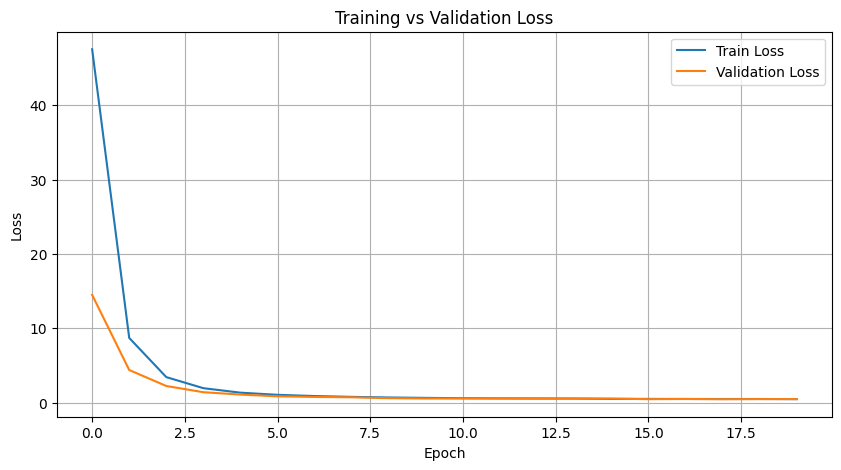

GRU(
  (lstm): GRU(1, 73, num_layers=2, batch_first=True)
  (predict): Linear(in_features=73, out_features=1, bias=True)
)

In [ ]:
train_model(model_gru, 20, train_loader=train_loader, valid_loader=valid_loader, project="LSTM for Jena", run_name="20e_lr0.001", file_name="LSTM")


In [ ]:
for model in [model_baseline, model_lstm, model_gru]:
  avg_mae, avg_rmse, mae_sum, rmse_sum = get_accuracy(model, test_loader=test_loader)
  print(f"avg_mae:{avg_mae}, avg_rmse:{avg_rmse}, mae_sum:{mae_sum} rmse_sum:{rmse_sum}")

avg_mae:0.001978081651031971, avg_rmse:0.0022507912945002317, mae_sum:6072.4755859375 rmse_sum:6909.6611328125
avg_mae:0.0017921662656590343, avg_rmse:0.00201285257935524, mae_sum:5501.7373046875 rmse_sum:6179.2177734375
avg_mae:0.0018712476594373584, avg_rmse:0.002114091068506241, mae_sum:5744.5078125 rmse_sum:6490.0078125


In [ ]:
model_lstm_3l = LSTM(num_layers=3)
model_lstm_4l = LSTM(num_layers=4)
model_gru_3l = GRU(num_layers=3)
model_gru_4l = GRU(num_layers=4)

Epoch 1/20, Train Loss: 56.0949, Val Loss: 17.0588
Epoch 2/20, Train Loss: 10.6654, Val Loss: 5.2063
Epoch 3/20, Train Loss: 4.1954, Val Loss: 2.6613
Epoch 4/20, Train Loss: 2.3892, Val Loss: 1.7292
Epoch 5/20, Train Loss: 1.6142, Val Loss: 1.2921
Epoch 6/20, Train Loss: 1.2219, Val Loss: 1.0955
Epoch 7/20, Train Loss: 1.0579, Val Loss: 0.9276
Epoch 8/20, Train Loss: 0.8817, Val Loss: 0.7940
Epoch 9/20, Train Loss: 0.7929, Val Loss: 0.6876
Epoch 10/20, Train Loss: 0.7143, Val Loss: 0.6941
Epoch 11/20, Train Loss: 0.6830, Val Loss: 0.6604
Epoch 12/20, Train Loss: 0.6640, Val Loss: 0.6248
Epoch 13/20, Train Loss: 0.6309, Val Loss: 0.5726
Epoch 14/20, Train Loss: 0.5899, Val Loss: 0.5562
Epoch 15/20, Train Loss: 0.5846, Val Loss: 0.5516
Epoch 16/20, Train Loss: 0.5671, Val Loss: 0.5797
Epoch 17/20, Train Loss: 0.5567, Val Loss: 0.5367
Epoch 18/20, Train Loss: 0.5371, Val Loss: 0.5699
Epoch 19/20, Train Loss: 0.5193, Val Loss: 0.4872
Epoch 20/20, Train Loss: 0.5404, Val Loss: 0.5291


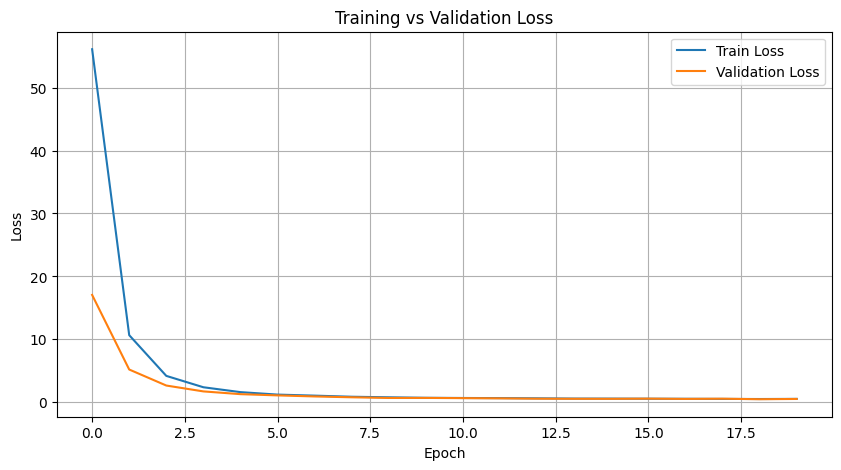

Epoch 1/20, Train Loss: 54.0370, Val Loss: 15.6657
Epoch 2/20, Train Loss: 11.0540, Val Loss: 4.8543
Epoch 3/20, Train Loss: 4.0609, Val Loss: 2.4077
Epoch 4/20, Train Loss: 2.2515, Val Loss: 1.6311
Epoch 5/20, Train Loss: 1.5521, Val Loss: 1.2288
Epoch 6/20, Train Loss: 1.2089, Val Loss: 1.0569
Epoch 7/20, Train Loss: 1.0156, Val Loss: 0.8438
Epoch 8/20, Train Loss: 0.8684, Val Loss: 0.7954
Epoch 9/20, Train Loss: 0.8171, Val Loss: 0.6922
Epoch 10/20, Train Loss: 0.7455, Val Loss: 0.6723
Epoch 11/20, Train Loss: 0.6746, Val Loss: 0.7191
Epoch 12/20, Train Loss: 0.6774, Val Loss: 0.6018
Epoch 13/20, Train Loss: 0.6350, Val Loss: 0.6395
Epoch 14/20, Train Loss: 0.6348, Val Loss: 0.5441
Epoch 15/20, Train Loss: 0.6007, Val Loss: 0.6256
Epoch 16/20, Train Loss: 0.5735, Val Loss: 0.5471
Epoch 17/20, Train Loss: 0.5813, Val Loss: 0.5798
Epoch 18/20, Train Loss: 0.5625, Val Loss: 0.5689
Epoch 19/20, Train Loss: 0.5465, Val Loss: 0.5350
Epoch 20/20, Train Loss: 0.5505, Val Loss: 0.7195


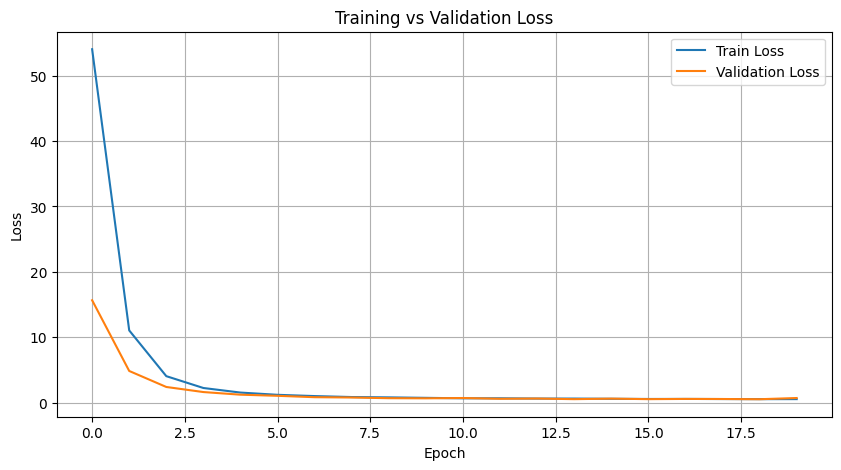

Epoch 1/20, Train Loss: 47.3731, Val Loss: 14.5726
Epoch 2/20, Train Loss: 8.9352, Val Loss: 4.7728
Epoch 3/20, Train Loss: 3.5711, Val Loss: 2.2076
Epoch 4/20, Train Loss: 2.0463, Val Loss: 1.4664
Epoch 5/20, Train Loss: 1.4261, Val Loss: 1.1153
Epoch 6/20, Train Loss: 1.1223, Val Loss: 0.9732
Epoch 7/20, Train Loss: 0.9355, Val Loss: 0.8163
Epoch 8/20, Train Loss: 0.8519, Val Loss: 0.7470
Epoch 9/20, Train Loss: 0.7411, Val Loss: 0.7296
Epoch 10/20, Train Loss: 0.7139, Val Loss: 0.5817
Epoch 11/20, Train Loss: 0.6670, Val Loss: 0.6075
Epoch 12/20, Train Loss: 0.6395, Val Loss: 0.5602
Epoch 13/20, Train Loss: 0.5911, Val Loss: 0.6668
Epoch 14/20, Train Loss: 0.5911, Val Loss: 0.5268
Epoch 15/20, Train Loss: 0.5804, Val Loss: 0.5802
Epoch 16/20, Train Loss: 0.5622, Val Loss: 0.5660
Epoch 17/20, Train Loss: 0.5636, Val Loss: 0.5456
Epoch 18/20, Train Loss: 0.5411, Val Loss: 0.5142
Epoch 19/20, Train Loss: 0.5431, Val Loss: 0.6689
Epoch 20/20, Train Loss: 0.5300, Val Loss: 0.4661


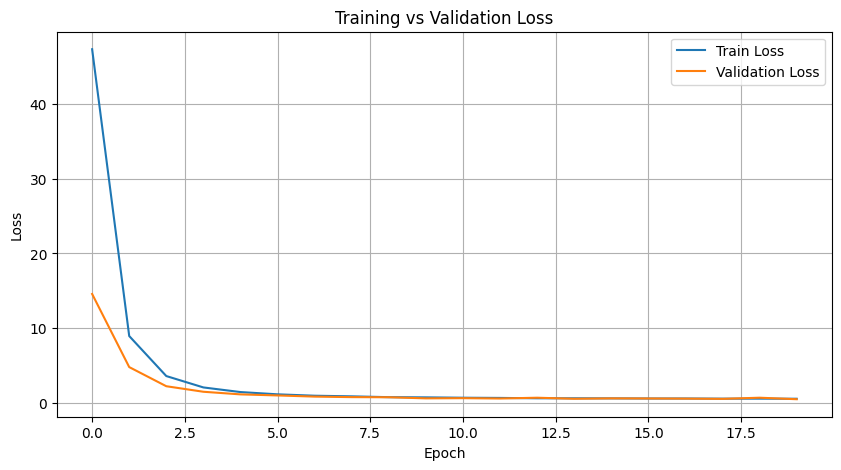

Epoch 1/20, Train Loss: 52.9406, Val Loss: 16.9804
Epoch 2/20, Train Loss: 9.9573, Val Loss: 4.6190
Epoch 3/20, Train Loss: 3.7611, Val Loss: 2.5012
Epoch 4/20, Train Loss: 2.1665, Val Loss: 1.5937
Epoch 5/20, Train Loss: 1.4884, Val Loss: 1.1225
Epoch 6/20, Train Loss: 1.1823, Val Loss: 1.3727
Epoch 7/20, Train Loss: 0.9892, Val Loss: 0.8443
Epoch 8/20, Train Loss: 0.8658, Val Loss: 0.7909
Epoch 9/20, Train Loss: 0.8226, Val Loss: 0.8022
Epoch 10/20, Train Loss: 0.7154, Val Loss: 0.6440
Epoch 11/20, Train Loss: 0.6641, Val Loss: 0.5932
Epoch 12/20, Train Loss: 0.6464, Val Loss: 0.6320
Epoch 13/20, Train Loss: 0.6104, Val Loss: 0.6605
Epoch 14/20, Train Loss: 0.6197, Val Loss: 0.5342
Epoch 15/20, Train Loss: 0.5887, Val Loss: 0.5451
Epoch 16/20, Train Loss: 0.6143, Val Loss: 0.6203
Epoch 17/20, Train Loss: 0.5775, Val Loss: 0.5202
Epoch 18/20, Train Loss: 0.5610, Val Loss: 0.5165
Epoch 19/20, Train Loss: 0.5503, Val Loss: 0.4862
Epoch 20/20, Train Loss: 0.5624, Val Loss: 0.5210


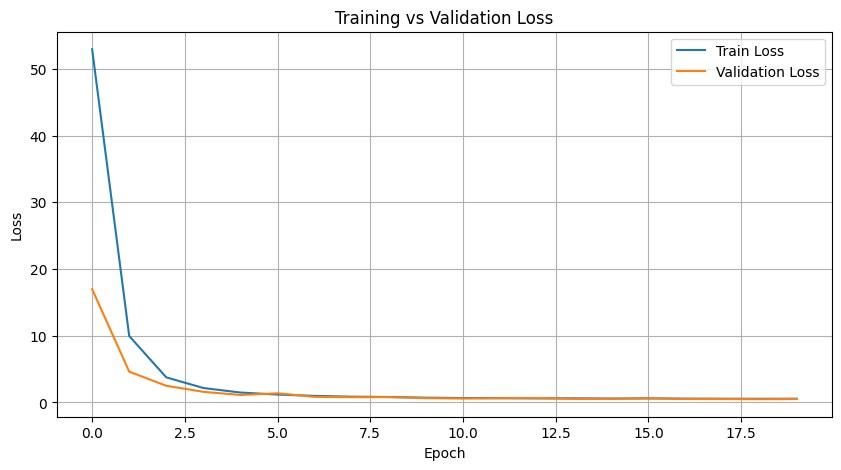

GRU(
  (lstm): GRU(1, 73, num_layers=4, batch_first=True)
  (predict): Linear(in_features=73, out_features=1, bias=True)
)

In [ ]:
train_model(model_lstm_3l, 20, train_loader=train_loader, valid_loader=valid_loader, file_name = "lstm_3l")
train_model(model_lstm_4l, 20, train_loader=train_loader, valid_loader=valid_loader, file_name = "lstm_4l")
train_model(model_gru_3l, 20, train_loader=train_loader, valid_loader=valid_loader, file_name = "gru_3l")
train_model(model_gru_4l, 20, train_loader=train_loader, valid_loader=valid_loader, file_name = "gru_4l")


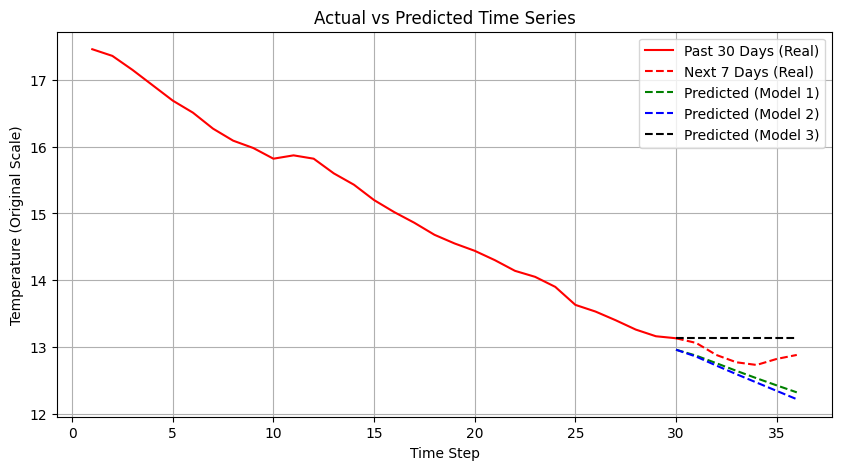

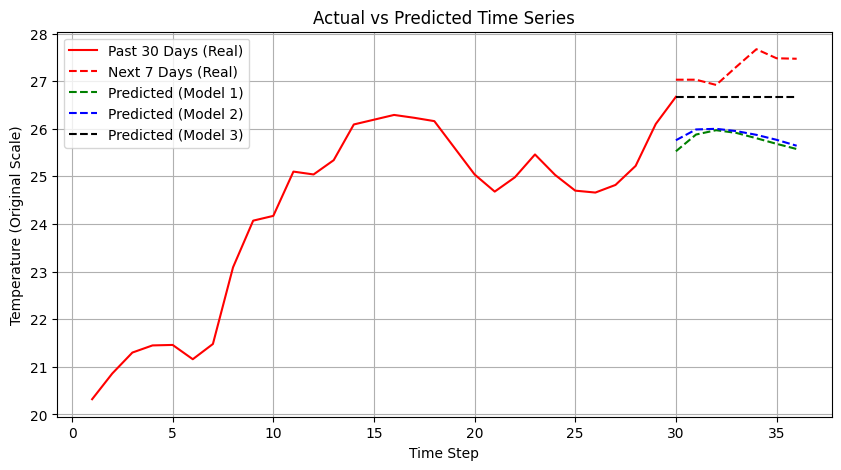

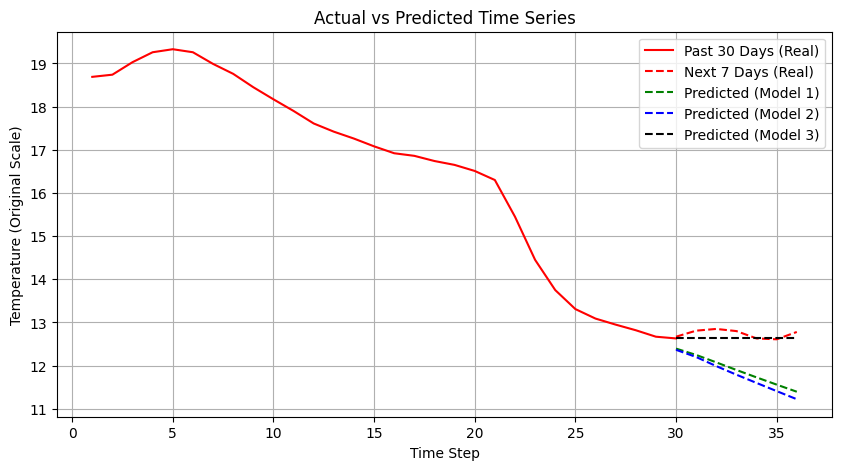

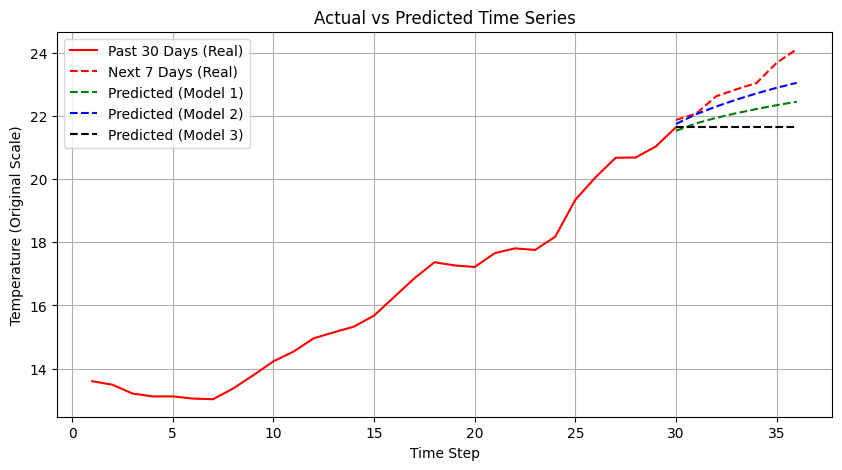

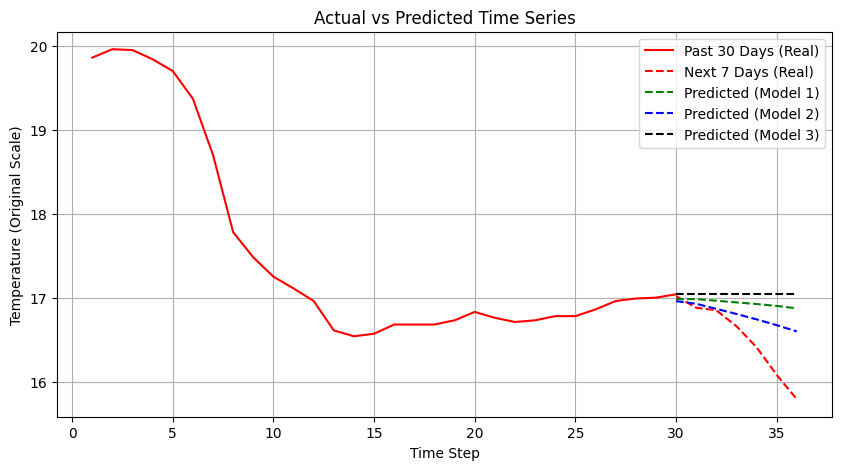

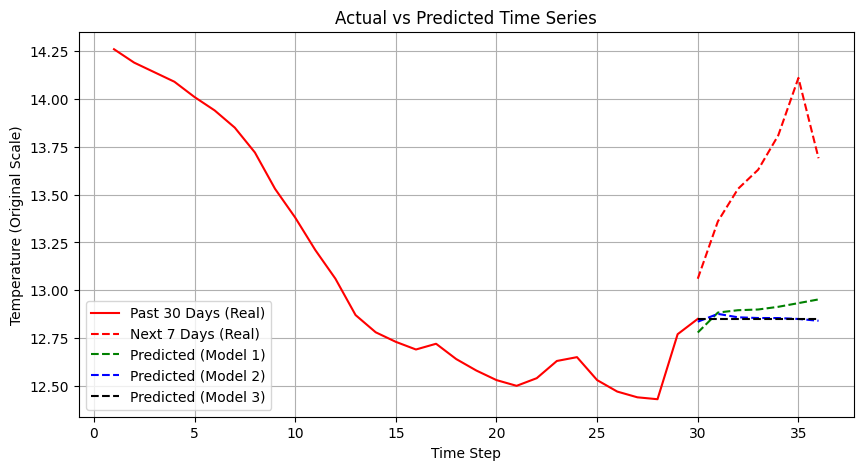

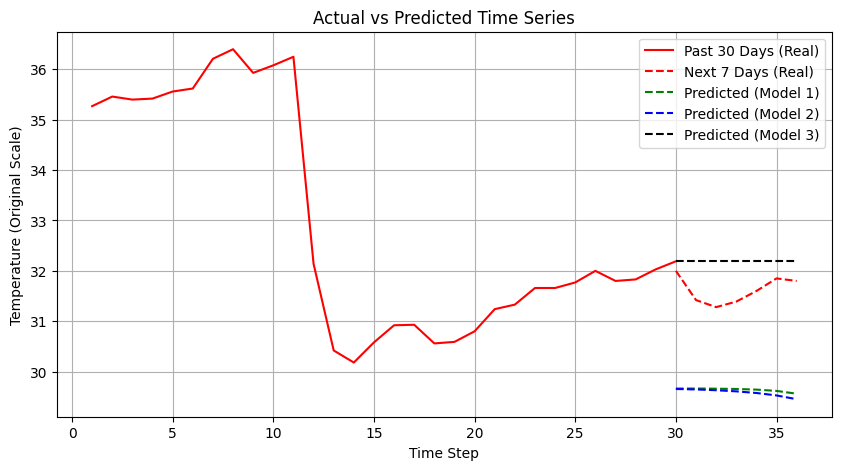

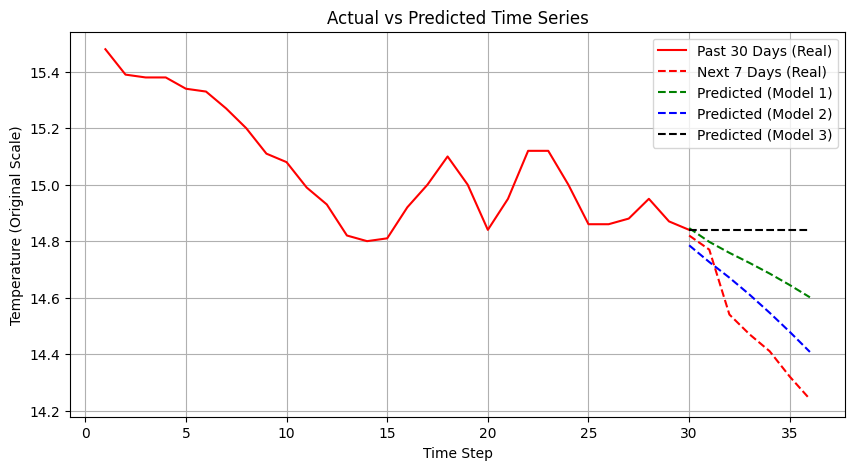

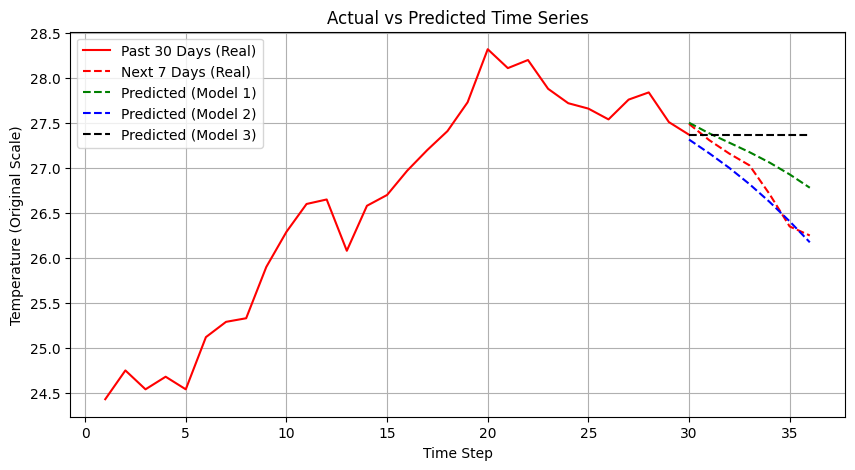

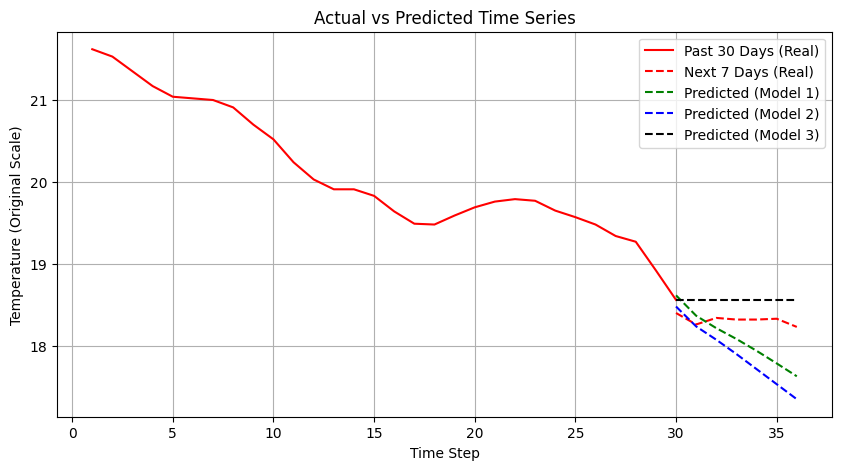

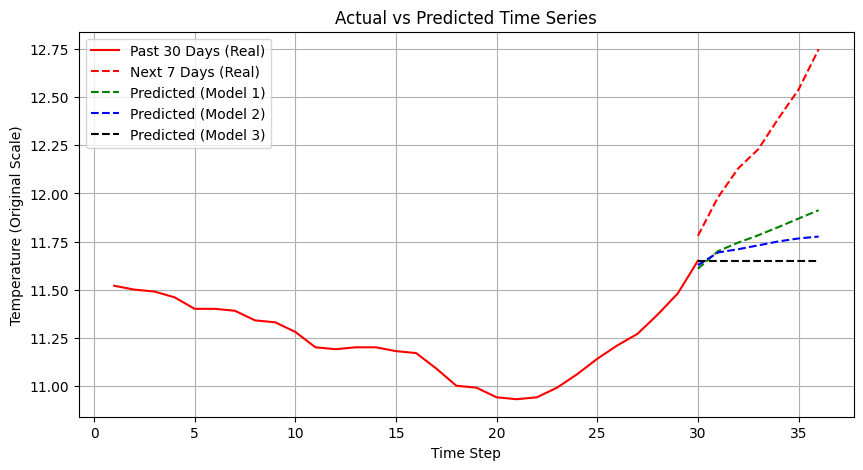

In [ ]:
limit = 10
for x, y in test_loader:
    plot_result([model_lstm, model_gru, model_baseline], ["green", "blue", "black"], [x[0], y[0]])
    if limit == 0:
      break
    limit -= 1


In [ ]:
print("Acc for lstm with increasing nr of layers: ")
for model in [model_lstm, model_lstm_3l, model_lstm_4l]:
  avg_mae, avg_rmse, mae_sum, rmse_sum = get_accuracy(model, test_loader=test_loader)
  print(f"avg_mae:{avg_mae}, avg_rmse:{avg_rmse}, mae_sum:{mae_sum} rmse_sum:{rmse_sum}")
print()

print("Acc for gru with increasing nr of layers: ")
for model in [model_gru, model_gru_3l, model_lstm_4l]:
  avg_mae, avg_rmse, mae_sum, rmse_sum = get_accuracy(model, test_loader=test_loader)
  print(f"avg_mae:{avg_mae}, avg_rmse:{avg_rmse}, mae_sum:{mae_sum} rmse_sum:{rmse_sum}")

Acc for lstm with increasing nr of layers: 
avg_mae:0.0017921662656590343, avg_rmse:0.00201285257935524, mae_sum:5501.7373046875 rmse_sum:6179.2177734375
avg_mae:0.001983184367418289, avg_rmse:0.002215478103607893, mae_sum:6088.14013671875 rmse_sum:6801.25439453125
avg_mae:0.0022416184656322002, avg_rmse:0.002498601796105504, mae_sum:6881.501953125 rmse_sum:7670.41015625

Acc for gru with increasing nr of layers: 
avg_mae:0.0018712476594373584, avg_rmse:0.002114091068506241, mae_sum:5744.5078125 rmse_sum:6490.0078125
avg_mae:0.0017629211070016026, avg_rmse:0.0019730913918465376, mae_sum:5411.9580078125 rmse_sum:6057.15576171875
avg_mae:0.0022416184656322002, avg_rmse:0.002498601796105504, mae_sum:6881.501953125 rmse_sum:7670.41015625


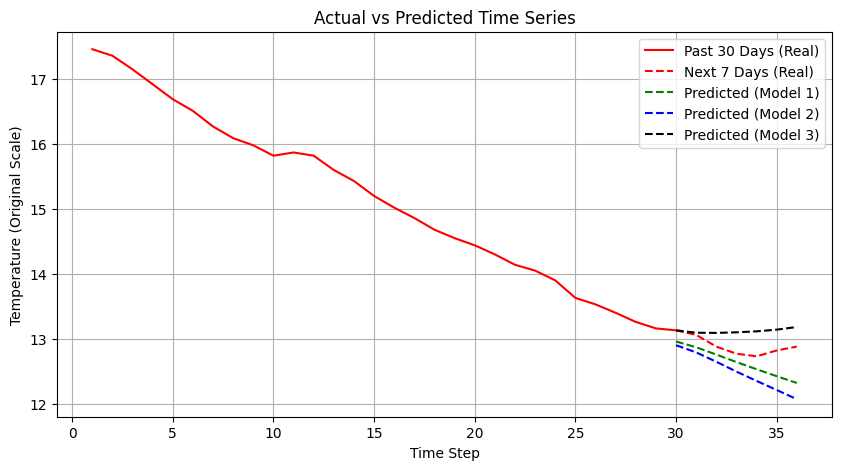

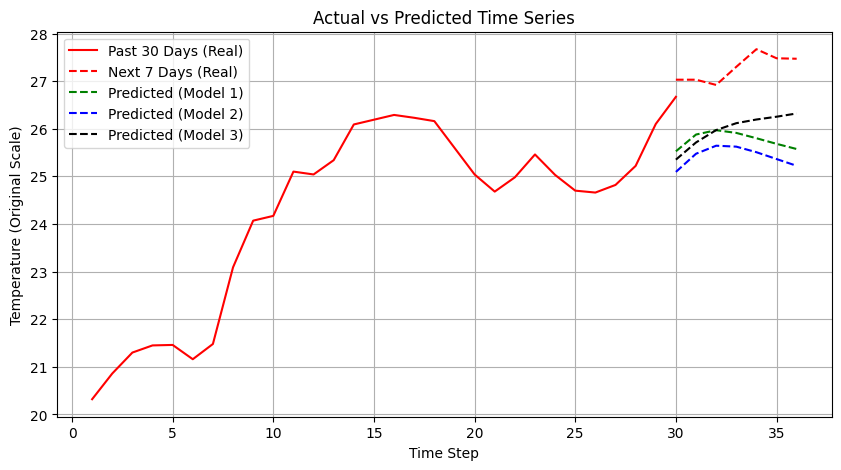

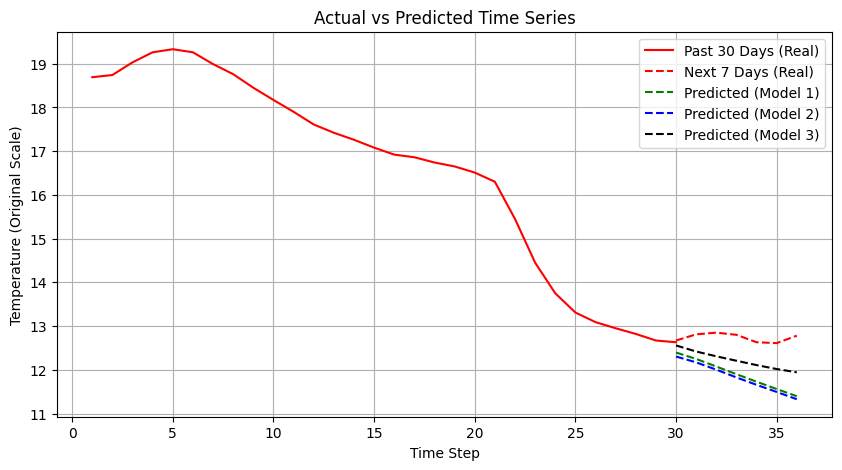

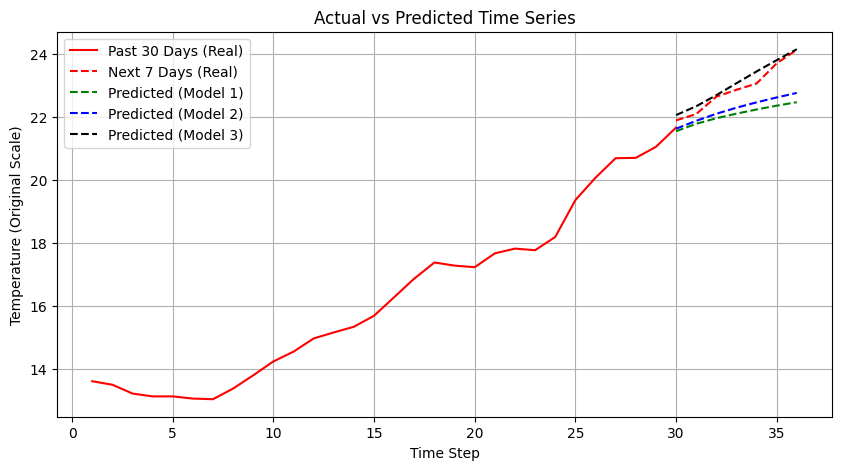

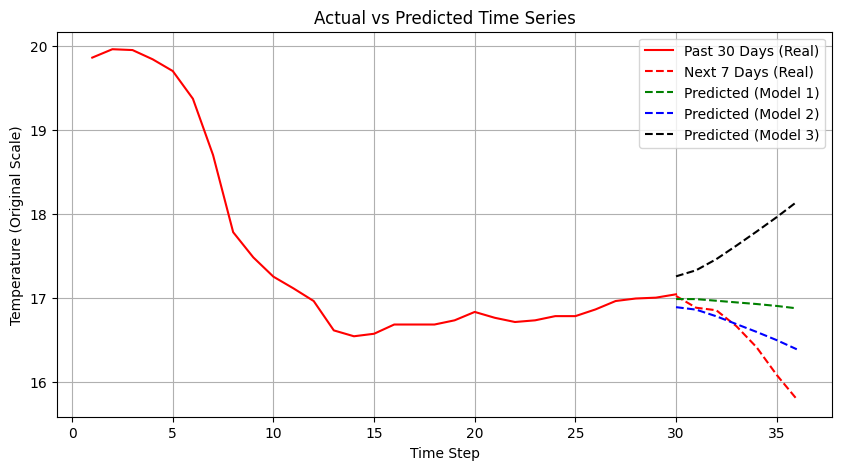

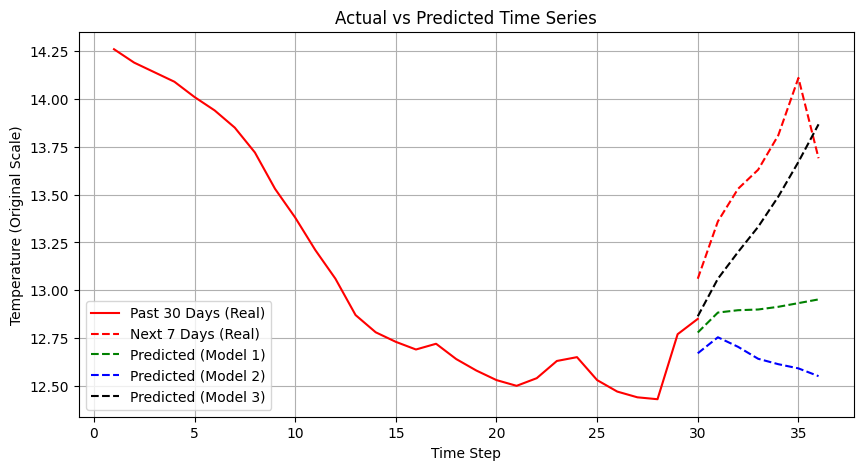

In [ ]:
limit = 5
for x, y in test_loader:
    plot_result([model_lstm, model_lstm_3l, model_lstm_4l], ["green", "blue", "black"], [x[0], y[0]])
    if limit == 0:
      break
    limit -= 1


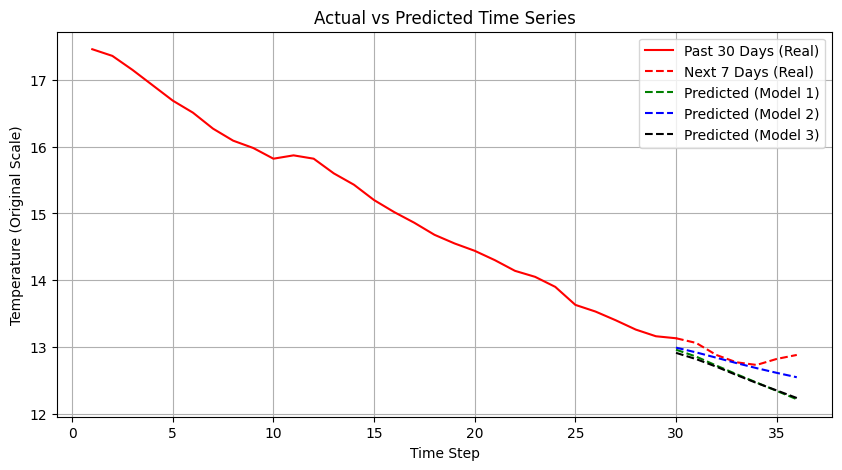

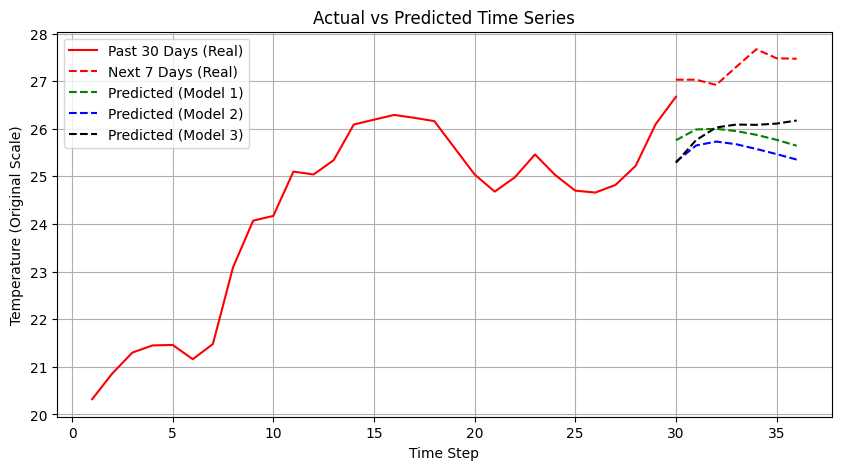

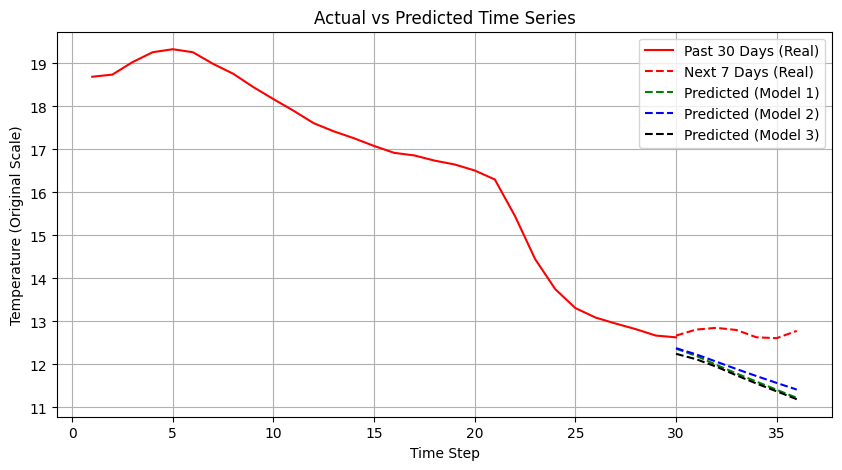

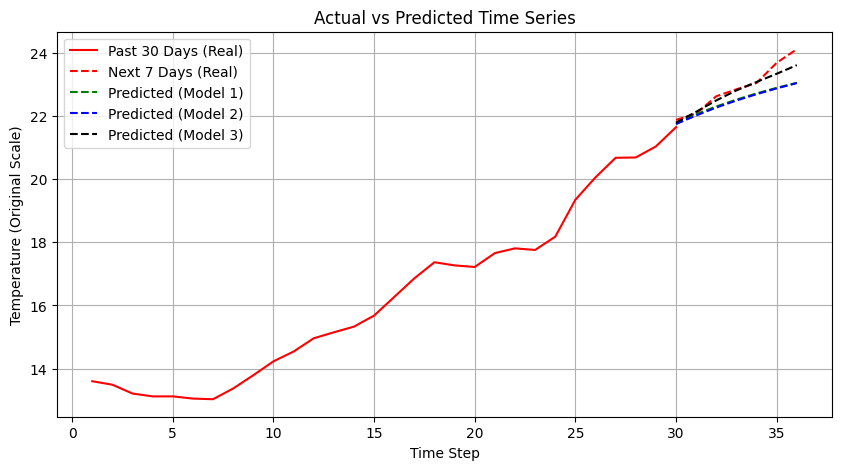

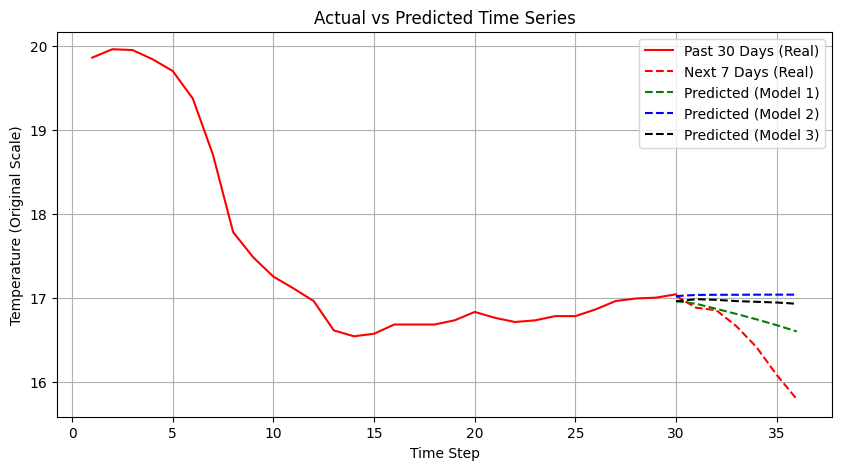

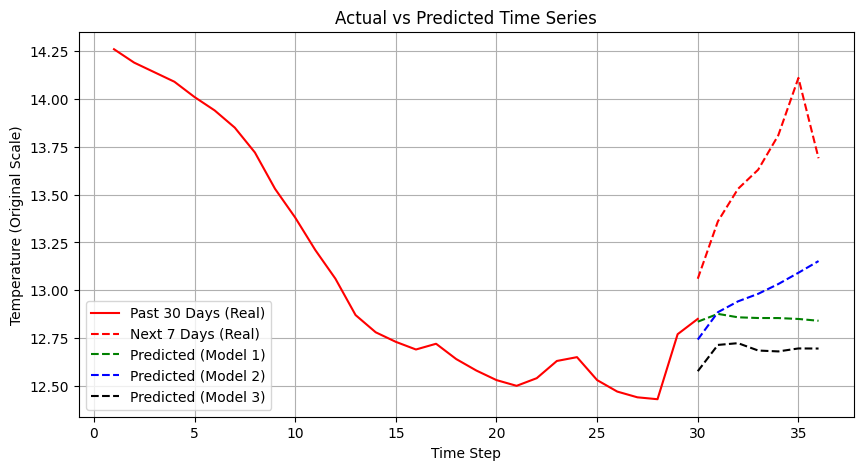

In [ ]:
limit = 5
for x, y in test_loader:
    plot_result([model_gru, model_gru_3l, model_gru_4l], ["green", "blue", "black"], [x[0], y[0]])
    if limit == 0:
      break
    limit -= 1


## Problem 2

In [117]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_size=1, seq_len=30, d_model=64, nhead=4, num_layers=2, dropout=0.1, output_size=1):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.output_size = output_size

        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, output_size)

    def forward(self, x):
        return self.predict_series(x, 7)

    def predict_series(self, x, series_len):
        predicted_series = []

        for _ in range(series_len):
            flow = self.input_proj(x)
            flow = self.pos_encoding(flow)
            flow = self.transformer(flow)
            last = flow[:, -1, :]
            pred = self.output_proj(last)
            predicted_series.append(pred)
            pred_expanded = pred.unsqueeze(1)
            x = torch.cat((x[:, 1:, :], pred_expanded), dim=1)

        return torch.cat(predicted_series, dim=1)


In [121]:
def rmse(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

def mae(preds, targets):
    return F.l1_loss(preds, targets)

def rmse(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

def mae(preds, targets):
    return F.l1_loss(preds, targets)

def get_accuracy(model, test_loader):
    model.eval()
    time_samples = [1, 3, 7]
    mae_sum = {x: 0 for x in time_samples}
    rmse_sum = {x: 0 for x in time_samples}
    count = 0
    device = "cpu"
    model.to(device)

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            count += X.size(0)

            for i in range(X.size(0)):
                x_sample = X[i].unsqueeze(0)
                y_sample = y[i]

                predicted = model(x_sample).squeeze(0)
                for horizon in time_samples:
                    mae_sum[horizon] += mae(predicted[:horizon], y_sample[:horizon])
                    rmse_sum[horizon] += rmse(predicted[:horizon], y_sample[:horizon])

    avg_mae = {horizon: mae_sum[horizon] / count for horizon in time_samples}
    avg_rmse = {horizon: rmse_sum[horizon] / count for horizon in time_samples}

    return avg_mae, avg_rmse, mae_sum, rmse_sum

In [76]:
train, valid, test = load_file("/content/jena_climate_2009_2016.csv")
train_loader, valid_loader, test_loader = get_loaders(train, valid, test, 7)

torch.Size([12011, 30, 1])


Epoch 1/15, Train Loss: 37.5400, Val Loss: 11.4599
Epoch 2/15, Train Loss: 8.9892, Val Loss: 7.5855
Epoch 3/15, Train Loss: 6.0591, Val Loss: 8.3741
No improvement for 1 epoch(s).
Epoch 4/15, Train Loss: 5.2302, Val Loss: 5.4931
Epoch 5/15, Train Loss: 23.2626, Val Loss: 7.5884
No improvement for 1 epoch(s).
Epoch 6/15, Train Loss: 7.9605, Val Loss: 6.0189
No improvement for 2 epoch(s).
Epoch 7/15, Train Loss: 6.5978, Val Loss: 5.3587
Epoch 8/15, Train Loss: 6.0227, Val Loss: 6.1311
No improvement for 1 epoch(s).
Epoch 9/15, Train Loss: 5.7566, Val Loss: 5.2235
Epoch 10/15, Train Loss: 5.5234, Val Loss: 4.6345
Epoch 11/15, Train Loss: 5.2863, Val Loss: 4.5444
Epoch 12/15, Train Loss: 5.1513, Val Loss: 4.3715
Epoch 13/15, Train Loss: 5.0635, Val Loss: 4.5511
No improvement for 1 epoch(s).
Epoch 14/15, Train Loss: 4.7839, Val Loss: 4.2037
Epoch 15/15, Train Loss: 4.7239, Val Loss: 3.9602


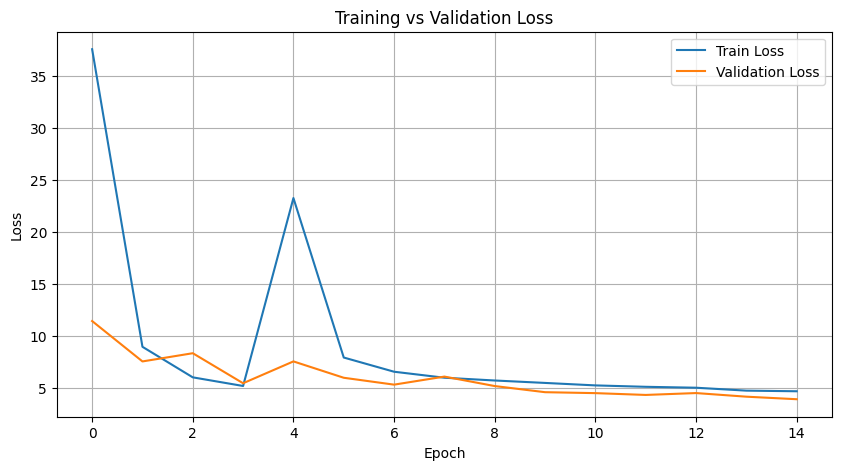

302.18173456192017


In [123]:
import time
model_transformer_2l = TransformerModel()
t1 = time.time()
train_model(model_transformer_2l, 15, train_loader,valid_loader, file_name="transformer" )
print(time.time() - t1)

Epoch 1/15, Train Loss: 35.7035, Val Loss: 11.4889
Epoch 2/15, Train Loss: 9.2828, Val Loss: 6.2119
Epoch 3/15, Train Loss: 7.5498, Val Loss: 5.5853
Epoch 4/15, Train Loss: 6.1454, Val Loss: 6.0574
No improvement for 1 epoch(s).
Epoch 5/15, Train Loss: 5.4986, Val Loss: 6.5206
No improvement for 2 epoch(s).
Epoch 6/15, Train Loss: 5.4491, Val Loss: 4.0652
Epoch 7/15, Train Loss: 5.5912, Val Loss: 5.7408
No improvement for 1 epoch(s).
Epoch 8/15, Train Loss: 5.5540, Val Loss: 4.9546
No improvement for 2 epoch(s).
Epoch 9/15, Train Loss: 5.0666, Val Loss: 4.4718
No improvement for 3 epoch(s).
Early stopping triggered after 9 epochs.


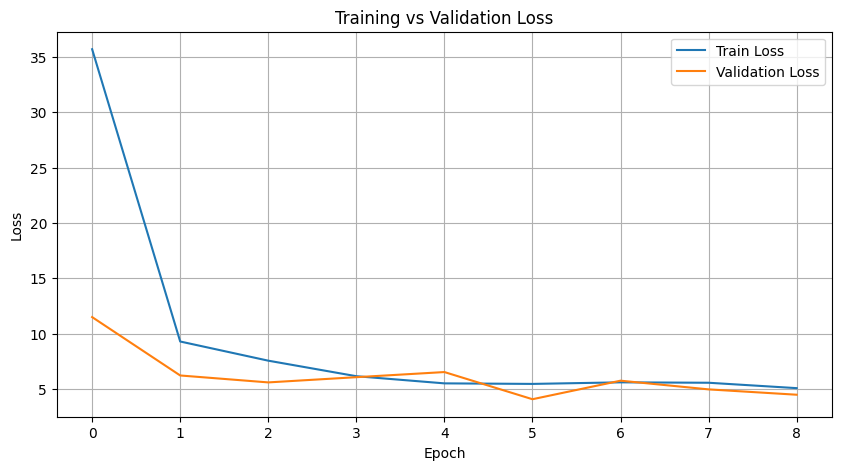

275.910391330719


In [124]:
model_transformer_3l = TransformerModel(num_layers=3)
t1 = time.time()
train_model(model_transformer_3l, 15, train_loader,valid_loader, file_name="transformer_3l")
print(time.time() - t1)

In [125]:
get_accuracy(model_transformer_3l, test_loader)

({1: tensor(1.4284), 3: tensor(1.5427), 7: tensor(1.6968)},
 {1: tensor(1.4284), 3: tensor(1.5610), 7: tensor(1.7406)},
 {1: tensor(17156.4160), 3: tensor(18529.4941), 7: tensor(20380.6270)},
 {1: tensor(17156.4160), 3: tensor(18749.6523), 7: tensor(20906.2129)})

In [126]:
get_accuracy(model_transformer_2l, test_loader)

({1: tensor(1.2016), 3: tensor(1.4128), 7: tensor(1.6216)},
 {1: tensor(1.2016), 3: tensor(1.4378), 7: tensor(1.6721)},
 {1: tensor(14432.4434), 3: tensor(16968.9883), 7: tensor(19477.4375)},
 {1: tensor(14432.4434), 3: tensor(17269.0605), 7: tensor(20083.2930)})